In [ ]:
%load_ext autoreload
%autoreload 2 # pour que les changements dans les modules soient pris en compte automatiquement

from google.colab import drive
drive.mount('/content/drive') # pour monter notre drive au notebook
project_path = '/content/drive/MyDrive/lewagon-deepdive/'

import sys; sys.path
sys.path.append('/content/drive/MyDrive/lewagon-deepdive/lewagon-deepdive') # pour pouvoir importer nos modules pratiques à utiliser dans les notebooks

Mounted at /content/drive


In [ ]:
from dataset import *
from data_preproc import *
from plot_loss_accuracy import plot_loss_accuracy

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_curve

from tensorflow.keras import layers,models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, load_img, img_to_array
from tensorflow.keras.metrics import AUC
from tensorflow.keras import regularizers
from tensorflow.math import confusion_matrix


# MODEL PARAMS

In [ ]:
model_nb=12 # IMPORTANT!!!!!!!!!!!!!!!!!!

In [ ]:
families_to_keep=[]
species_to_keep=[]
min_duration=1
target_time=5
target='species' # or species

## Generate Dataframe with specific features

In [ ]:
df= get_dataset('/content/drive/MyDrive/lewagon-deepdive/raw_data/watkins_sound_list.csv',families_to_keep= families_to_keep,species_to_keep=species_to_keep,min_duration=min_duration)

### Class distribution

In [ ]:
(df_duration.loc['BA2A']['duration']/df_duration.duration.sum())*100

26.987941889501567

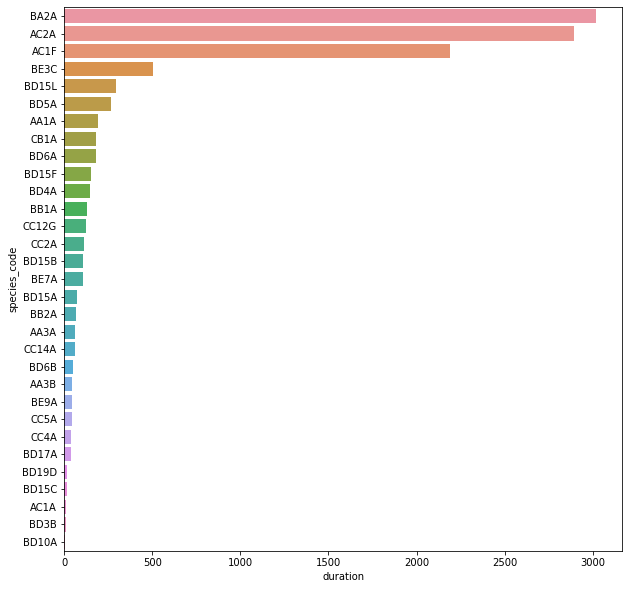

In [ ]:
df_duration = df.groupby(['species_code']).sum()
df_duration.sort_values(by='duration', ascending=False, inplace = True)


plt.figure(figsize=(10,10))
sns.barplot(x=df_duration.duration, y=df_duration.index);

In [ ]:
over_r =['BA2A','AC2A','AC1F'] # defining over-represented classes
under_r =['BE3C','BD15L','BD5A','AA1A','CB1A','BD6A','BD15F','BD4A','BB1A','CC12G','CC2A',
          'BD15B','BE7A','BD15A','BB2A','AA3A','CC14A','BD6B','AA3B','BE9A','CC5A','CC4A','BD17A','BD19D',
          'BD15C','AC1A','BD3B','BD10A'] # defining under-represented classes

# Preprocessing

## Generating list of tuples (audio data, code)

In [ ]:
input_list= get_list_of_tuples(df, '/content/drive/MyDrive/lewagon-deepdive/raw_data/watkins_audio_files', target=target, sr=44_100, nb_rows=None)

KeyboardInterrupt: ignored

## Generating Train, Val and Test sets

In [ ]:
train_set,val_set, test_set = enhanced_dataset_split(input_list,df, test_size=0.2,threshold=0.5,target=target) # train val test split

below_train,above_train = split_above_below(train_set, target_time,44100) # split between files above and below target_time
below_test, above_test = split_above_below(test_set, target_time,44100)
below_val, above_val = split_above_below(val_set, target_time,44100)

above_train_samples = train_split_above_samples(above_train,over_r,under_r, target_time, 44100,audio_manipulation=True) # preprocessing samples above target_time
below_train_samples = train_split_below_samples(below_train,over_r,under_r, target_time, 44100,audio_manipulation=True) # preprocessing samples below target_time

above_val_samples = val_test_split_above_samples(above_val, target_time, 44100)
below_val_samples = val_test_split_below_samples(below_val, target_time, 44100)

above_test_samples = val_test_split_above_samples(above_test, target_time, 44100)
below_test_samples = val_test_split_below_samples(below_test, target_time, 44100)

preproc_train_set= final_set(above_train_samples,below_train_samples) # compiling final set
preproc_val_set= final_set(above_val_samples,below_val_samples)
preproc_test_set= final_set(above_test_samples,below_test_samples)

In [ ]:
len(preproc_train_set)

2879

## Removing samples for over-represented categories

### Train set

In [ ]:
temp_df=pd.DataFrame(preproc_train_set)

species= over_r + under_r

df_=temp_df[temp_df[1] == species[0]].reset_index(drop=True).loc[0:150]

for spcs in species[1:]: 
  df_=pd.concat([df_,temp_df[temp_df[1] == spcs].reset_index(drop=True).loc[0:150]])

preproc_train_set= df_.values.tolist()

### Val set

In [ ]:
temp_df=pd.DataFrame(preproc_val_set)

species= over_r + under_r

df_=temp_df[temp_df[1] == species[0]].reset_index(drop=True).loc[0:40]

for spcs in species[1:]: 
  df_=pd.concat([df_,temp_df[temp_df[1] == spcs].reset_index(drop=True).loc[0:40]])

preproc_val_set= df_.values.tolist()

### Test set

In [ ]:
temp_df=pd.DataFrame(preproc_test_set)

species= over_r + under_r

df_=temp_df[temp_df[1] == species[0]].reset_index(drop=True).loc[0:40]

for spcs in species[1:]: 
  df_=pd.concat([df_,temp_df[temp_df[1] == spcs].reset_index(drop=True).loc[0:40]])

preproc_test_set= df_.values.tolist()

# Creating X and y

## Generating Mel spectrograms

In [ ]:
preproc_train_set= get_arrays_from_audio(preproc_train_set) 
preproc_val_set= get_arrays_from_audio(preproc_val_set)
preproc_test_set= get_arrays_from_audio(preproc_test_set)

## X and y

In [ ]:
X_train=[]
y_train=[]

for x,y in preproc_train_set:
  X_train.append(x)
  y_train.append(y)

X_train=np.array(X_train)
y_train=np.array(y_train)

X_val=[]
y_val=[]

for x,y in preproc_val_set:
  X_val.append(x)
  y_val.append(y)

X_val=np.array(X_val)
y_val=np.array(y_val)

X_test=[]
y_test=[]

for x,y in preproc_test_set:
  X_test.append(x)
  y_test.append(y)

X_test=np.array(X_test)
y_test=np.array(y_test)

In [ ]:
X_train.shape

(2156, 128, 431)

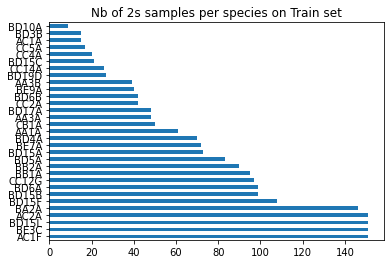

In [ ]:
pd.Series(y_train).value_counts().plot(kind='barh')
plt.title('Nb of 2s samples per species on Train set');

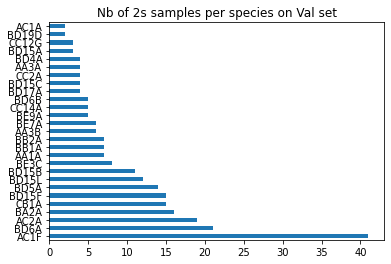

In [ ]:
pd.Series(y_val).value_counts().plot(kind='barh')
plt.title('Nb of 2s samples per species on Val set');

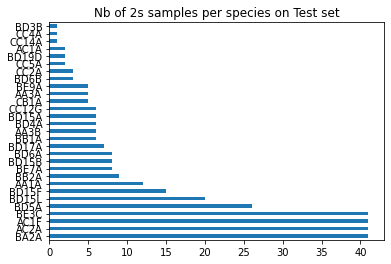

In [ ]:
pd.Series(y_test).value_counts().plot(kind='barh')
plt.title('Nb of 2s samples per species on Test set');

In [ ]:
X_train= np.expand_dims(X_train,-1) # expanding dims to get 1 channel
X_val=np.expand_dims(X_val,-1)
X_test=np.expand_dims(X_test,-1)

In [ ]:
X_train.shape , X_val.shape, X_test.shape

((2156, 128, 431, 1), (250, 128, 431, 1), (337, 128, 431, 1))

## Encoding target

In [ ]:
le = LabelEncoder()

y_train=le.fit_transform(y_train)
y_train=to_categorical(y_train,31)

y_val=le.transform(y_val)
y_val=to_categorical(y_val,31)

y_test=le.transform(y_test)
y_test=to_categorical(y_test,31)


In [ ]:
y_train.shape, y_val.shape, y_test.shape

((2156, 31), (250, 31), (337, 31))

# Model 

In [ ]:
reg_l1 = regularizers.L1(0.01)
reg_l2 = regularizers.L2(0.01)
reg_l1_l2 = regularizers.l1_l2(l1=0.005, l2=0.0005)

# Instantiate model
model = models.Sequential()

# 1st conv layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.MaxPool2D((3, 3)))
model.add(layers.BatchNormalization()) # normalizes the activation at the layer, speeds up training
          
# 2nd conv layer
model.add(layers.Conv2D(48, (3, 3), activation='relu'))
model.add(layers.MaxPool2D((3, 3)))
model.add(layers.BatchNormalization())
              
# 3rd conv layer
model.add(layers.Conv2D(48, (2, 2), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.BatchNormalization())

#4th conv layer
model.add(layers.Conv2D(32, (2, 2), activation='relu'))
model.add(layers.MaxPool2D((2, 2)))
model.add(layers.BatchNormalization())

# flatten output and feed it into dense layer
model.add(layers.Flatten()) # flatten conv output
model.add(layers.Dense(64, activation='relu',bias_regularizer=reg_l2, kernel_regularizer=reg_l2))
model.add(layers.Dropout(0.2)) # randomly drops neurons
        
# output layer that uses softmax
model.add(layers.Dense(y_train.shape[1], activation='softmax')) # number of neurons of the classifications we want to predict


# compile the network
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, 
              loss="categorical_crossentropy",
              metrics=['accuracy',AUC()])

# Train the cnn 
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=16, epochs=100)

Epoch 1/100
135/135 [==============================] - 3s 15ms/step - loss: 3.7576 - accuracy: 0.3256 - auc_39: 0.8433 - val_loss: 11.8796 - val_accuracy: 0.1080 - val_auc_39: 0.5700
Epoch 2/100
135/135 [==============================] - 2s 12ms/step - loss: 2.3781 - accuracy: 0.4606 - auc_39: 0.9314 - val_loss: 3.6750 - val_accuracy: 0.3560 - val_auc_39: 0.8133
Epoch 3/100
135/135 [==============================] - 2s 12ms/step - loss: 2.1590 - accuracy: 0.5301 - auc_39: 0.9517 - val_loss: 2.7574 - val_accuracy: 0.4200 - val_auc_39: 0.9121
Epoch 4/100
135/135 [==============================] - 2s 12ms/step - loss: 1.9491 - accuracy: 0.6081 - auc_39: 0.9642 - val_loss: 2.2649 - val_accuracy: 0.5000 - val_auc_39: 0.9485
Epoch 5/100
135/135 [==============================] - 2s 13ms/step - loss: 1.9516 - accuracy: 0.6238 - auc_39: 0.9679 - val_loss: 3.8638 - val_accuracy: 0.2880 - val_auc_39: 0.8197
Epoch 6/100
135/135 [==============================] - 2s 13ms/step - loss: 1.8110 - accu

## Plot Loss and Accuracy

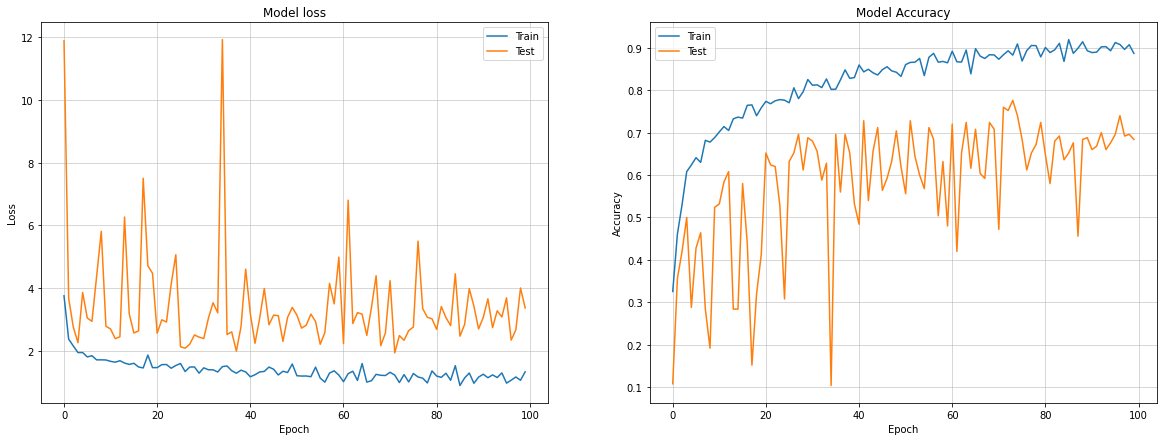

In [ ]:
plot_loss_accuracy(history)

## Evaluating Model on Test set

In [ ]:
print(f'Model Accuracy: {round(model.evaluate(X_test,y_test,verbose=0)[1],2)*100}%')
print(f'Model AUC: {round(model.evaluate(X_test,y_test,verbose=0)[2],2)}')

Model Accuracy: 79.0%
Model AUC: 0.95


### Classification report

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
print(classification_report(np.argmax(y_test,axis=1),np.argmax(model.predict(X_test),axis=1)))

              precision    recall  f1-score   support

           0       0.56      0.83      0.67        12
           1       1.00      0.60      0.75         5
           2       1.00      0.83      0.91         6
           3       1.00      1.00      1.00         2
           4       1.00      1.00      1.00        41
           5       1.00      1.00      1.00        41
           6       0.92      0.83      0.87        41
           7       0.42      0.83      0.56         6
           8       0.86      0.67      0.75         9
          10       0.43      1.00      0.60         6
          11       0.71      0.62      0.67         8
          12       0.00      0.00      0.00         0
          13       0.50      0.93      0.65        15
          14       0.94      0.85      0.89        20
          15       0.83      0.71      0.77         7
          16       1.00      1.00      1.00         2
          17       0.00      0.00      0.00         1
          18       0.25    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1

## Predict

In [ ]:
model.predict(X_test[5].reshape((1,) + X_test[5].shape)) , y_test[5]

(array([[6.7043560e-10, 3.5018837e-07, 1.2783509e-10, 2.1105181e-16,
         1.4695428e-12, 2.1765279e-06, 2.9767126e-01, 2.0583705e-07,
         3.7459002e-05, 4.6592945e-06, 3.6326719e-06, 6.8835527e-01,
         2.8981967e-06, 7.3371802e-09, 4.2994552e-10, 1.1418919e-10,
         1.1109590e-08, 2.5756908e-09, 5.3126313e-04, 1.9087921e-03,
         1.1330410e-02, 9.1482030e-11, 8.3820287e-06, 6.0407988e-06,
         1.9299845e-11, 5.5412153e-07, 1.3723365e-10, 1.1893530e-04,
         1.4769248e-08, 1.5779272e-13, 1.7691107e-05]], dtype=float32),
 array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       dtype=float32))

# Save model

In [ ]:
!mkdir -p /content/drive/MyDrive/lewagon-deepdive/working_environment/03.model_training/models/model_12/cut_5s

save_path=f'/content/drive/MyDrive/lewagon-deepdive/working_environment/03.model_training/models/model_12/cut_5s/'

In [ ]:
joblib.dump(model, save_path+ '/model.joblib')

INFO:tensorflow:Assets written to: ram://82c44cc8-466f-4c30-8ae8-19b21a7eaf38/assets


['/content/drive/MyDrive/lewagon-deepdive/working_environment/03.model_training/models/model_12/uncut_5s//model.joblib']

In [ ]:
plot_loss_accuracy(history)
plt.savefig(save_path+ '/plot.png')

In [ ]:
model= joblib.load('/content/drive/MyDrive/lewagon-deepdive/working_environment/03.model_training/models/model_12/new_preproc/uncut_5s/model.joblib')

successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = models.Model(inputs = model.input, outputs = successive_outputs)

x=X_test[5]

x= x.reshape((1,) + x.shape)

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(feature_map.shape)

  plt.figure(figsize=(400,100))
  for i in range(1,n_features):
    plt.subplot(48,1,i) 
    x  = feature_map[0, :, :, i]
    plt.imshow(x)
  plt.savefig(save_path +f'/kernels_{j}.png')

NameError: ignored

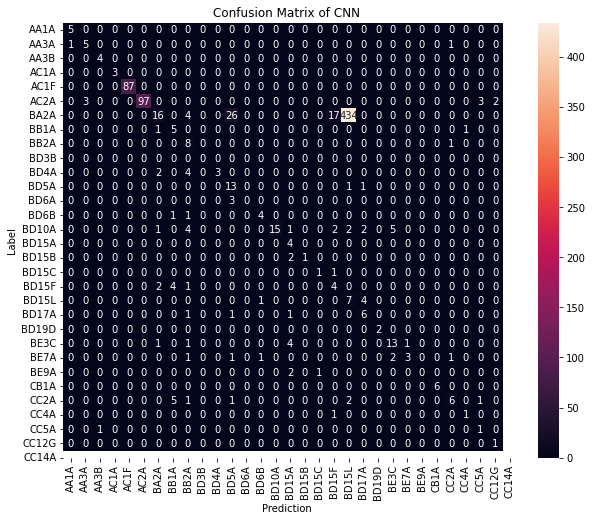

In [ ]:
ypred_array = np.array([])

for i in range(len(X_test)):
    X = X_test[i]
    X = X[np.newaxis, ...] # to make a 4D
    
    # prediction
    prediction = model.predict(X)
    
    # extract the index with the max value
    predicted_index = np.argmax(prediction, axis=1)
    ypred_array = np.append(ypred_array, predicted_index)

confusion_mtx = confusion_matrix(np.argmax(y_test,axis=1), ypred_array) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=df['species_code'].unique(), yticklabels=df['species_code'].unique(), 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title("Confusion Matrix of CNN")
plt.savefig(save_path + '/confusion_matrix.png', bbox_inches='tight')
plt.show();

In [ ]:
# # roc curve for classes
# fpr = {}
# tpr = {}
# thresh ={}

# name=df['species_code'].unique()
# n_class = 31

# for i in range(n_class):    
#     prediction = model.predict(X_test)
#     predicted_index = np.argmax(prediction, axis=1)
#     fpr[i], tpr[i], thresh[i] = roc_curve(np.argmax(y_test,axis=1), model.predict(X_test)[:,i], pos_label=i)
#     plt.plot(fpr[i], tpr[i], linestyle='--', label=f'Class {name[i]} vs Rest')

# fig=plt.figure(figsize=(15,5))
# plt.title('Multiclass ROC curve')
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive rate')
# plt.legend(loc='best')
# plt.savefig(save_path + '/multiclass_ROC.png',dpi=300); 

# Preprocessing tests

In [ ]:
import librosa

In [ ]:
def add_white_noise(signal,noise_factor):
  noise = np.random.normal(0, signal.std(),signal.size)
  augmented_signal = signal + noise * noise_factor
  return augmented_signal

In [ ]:
signal , sr = librosa.load('/content/drive/MyDrive/lewagon-deepdive/raw_data/watkins_audio_files/AA1A_7202100T.wav')

In [ ]:
noise_signal = add_white_noise(signal,0.5)

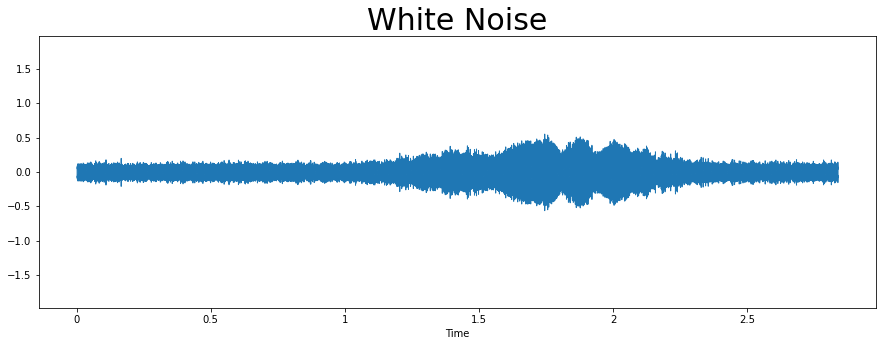

In [ ]:
plt.figure(figsize=(15,5))

librosa.display.waveshow(noise_signal)
plt.ylim(bottom , top)
plt.title('White Noise',fontsize=30);

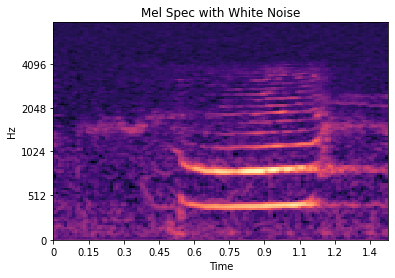

In [ ]:
S = librosa.feature.melspectrogram(y=noise_signal, sr=44100) # Compute a mel-scaled spectrogram
S_DB = librosa.power_to_db(S, ref=np.max) # Convert a power spectrogram (amplitude squared) to decibel (dB) units
librosa.display.specshow(S_DB, x_axis='time',
                         y_axis='mel', sr=44100,
                         fmax=8000)
plt.title('Mel Spec with White Noise');

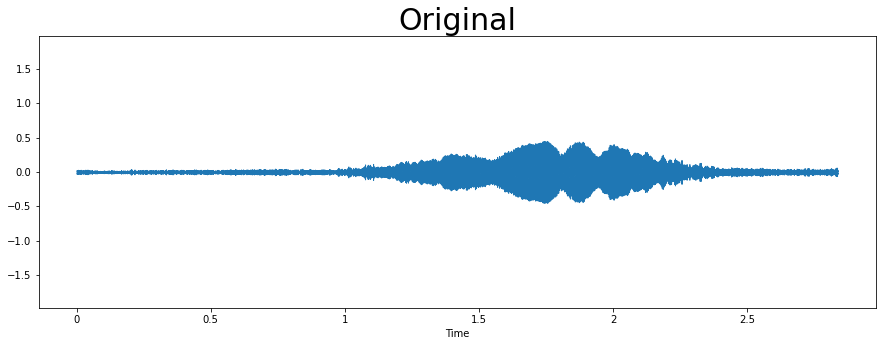

In [ ]:
plt.figure(figsize=(15,5))

librosa.display.waveshow(signal)
plt.ylim(bottom , top)
plt.title('Original',fontsize=30);

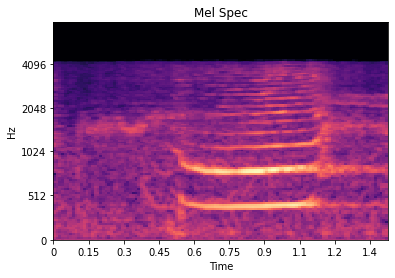

In [ ]:
S = librosa.feature.melspectrogram(y=signal, sr=44100) # Compute a mel-scaled spectrogram
S_DB = librosa.power_to_db(S, ref=np.max) 
librosa.display.specshow(S_DB, x_axis='time',
                         y_axis='mel', sr=44100,
                         fmax=8000)
plt.title('Mel Spec');

In [ ]:
def random_gain(signal, min_gain_factor, max_gain_factor):
  gain_factor= random.uniform(min_gain_factor,max_gain_factor)
  return signal * gain_factor

(-1.9768446922302245, 1.9768446922302245)

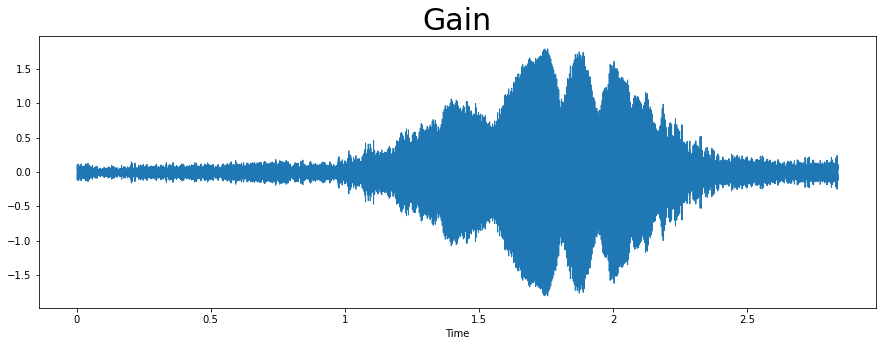

In [ ]:
augmented_signal = random_gain(signal,2,4)

plt.figure(figsize=(15,5))

librosa.display.waveshow(augmented_signal)
plt.title('Gain',fontsize=30);
bottom, top = plt.ylim()  # return the current ylim
bottom , top

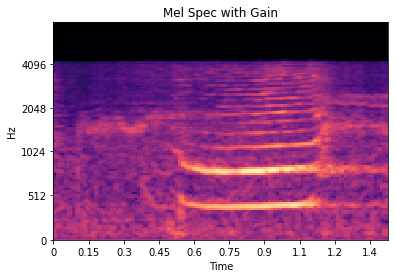

In [ ]:
S = librosa.feature.melspectrogram(y=augmented_signal, sr=44100) # Compute a mel-scaled spectrogram
S_DB = librosa.power_to_db(S, ref=np.max) 
librosa.display.specshow(S_DB, x_axis='time',
                         y_axis='mel', sr=44100,
                         fmax=8000)
plt.title('Mel Spec with Gain');